In [257]:
cd ~/dv/PyChop/SNS

/SNS/users/lj7/dv/mantid/mantid/scripts/PyChop/SNS


In [1]:
import os, sys, glob, numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
ls -lt /SNS/ARCS/2009_2_18_SCI/shared/C4H2I2S/C4H2I2S_50K_100meV/

total 495104
-rw-rwxr-- 1 snsdata users   4180486 Jul 22  2013 slice_n_c_m3_C4H2I2S_50K_100meV.phx*
-rw-rwxr-- 1 snsdata users 356234428 Jul 22  2013 slice_n_c_m3_C4H2I2S_50K_100meV.spe*
-rw-rwxr-- 1 snsdata users    956616 Jul 22  2013 smask_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users  12010784 Jul 22  2013 ipdpe_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users  36107344 Jul 22  2013 ipdpe_n_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users  49515822 Jul 22  2013 ipdpe_n_c_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users  45845468 Jul 22  2013 ipdpe_n_c_m3_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users    682887 Jul 22  2013 iphie_n_c_m3_C4H2I2S_50K_100meV.h5*
-rw-rwxr-- 1 snsdata users    908192 Jul 22  2013 iqe_n_c_m3_C4H2I2S_50K_100meV.h5*


In [5]:
import histogram.hdf as hh, histogram as H
from multiphonon import sqe

In [6]:
iqe = hh.load('/SNS/ARCS/2009_2_18_SCI/shared/C4H2I2S/C4H2I2S_50K_100meV/iqe_n_c_m3_C4H2I2S_50K_100meV.h5')

<IPython.core.display.Javascript object>


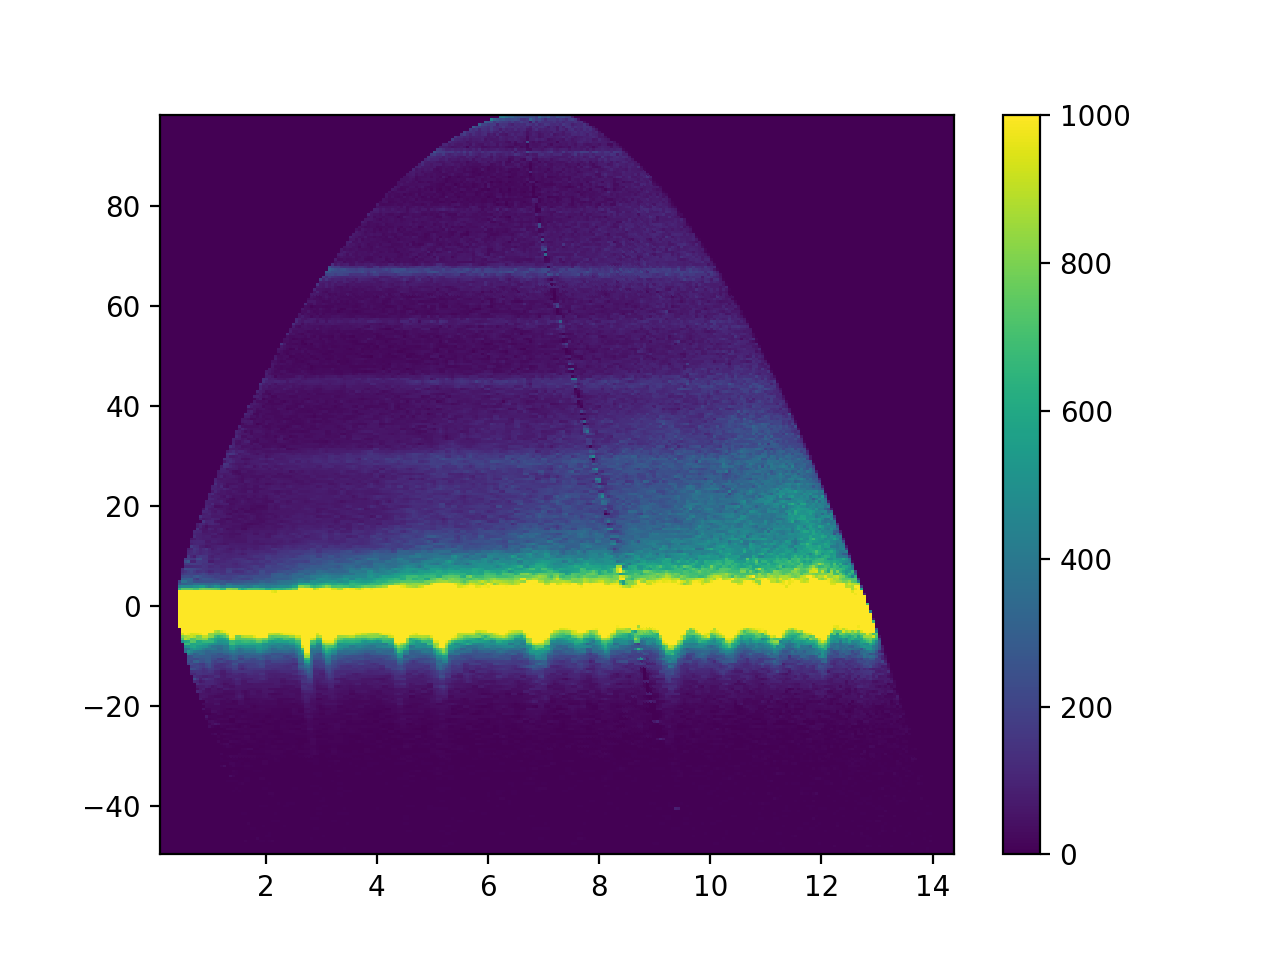

In [7]:
plt.figure()
sqe.plot(iqe)
plt.clim(0, 1000)

In [194]:
ie = iqe[(5,9), ()].sum('Q')

<IPython.core.display.Javascript object>


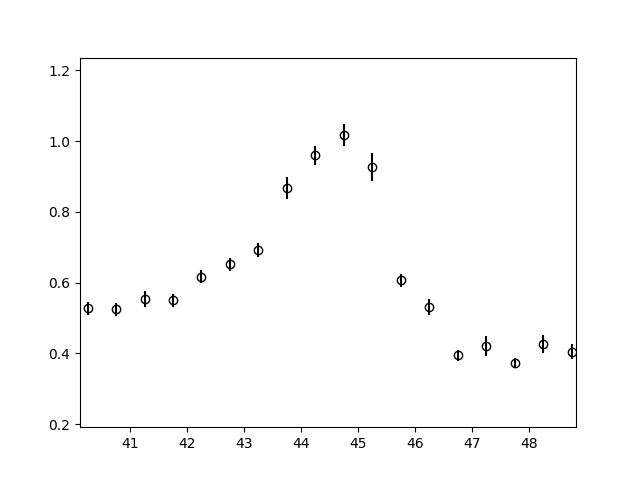

(0, 2)

In [195]:
plt.figure()
plt.errorbar(ie.energy, ie.I/1e4, ie.E2**.5/1e4, fmt='o', markerfacecolor='none', color='k')
plt.xlim(-20, 100)
plt.ylim(0, 2)

# Fit

First try the elastic peak

In [10]:
from dgsres import icg

In [17]:
import lmfit

In [21]:
class EEModel:

    def __init__(self, sigma_left, sigma_right, weight_left, ef_width):
        self.sigma_left = sigma_left
        self.sigma_right = sigma_right
        self.weight_left = weight_left
        self.ef_width = ef_width
        return
    
    def __call__(self, x):
        from scipy.special import erfc
        from dgsres.singlextal import fit_2d_psf
        weight_left = self.weight_left
        weight_right = 1.0 - weight_left
        sigma_left = self.sigma_left
        sigma_right = self.sigma_right
        ef_width = self.ef_width
        t1 = fit_2d_psf.gaus(x, 1./np.sqrt(2*np.pi)/np.abs(sigma_left), 0., sigma_left) * (1-erfc(x/ef_width)/2.)
        t2 = fit_2d_psf.gaus(x, 1./np.sqrt(2*np.pi)/np.abs(sigma_right), 0., sigma_right) * erfc(x/ef_width)/2.
        return t1*weight_left + t2*weight_right

In [13]:
pk_56 = ie[(52, 58.5)]

<IPython.core.display.Javascript object>


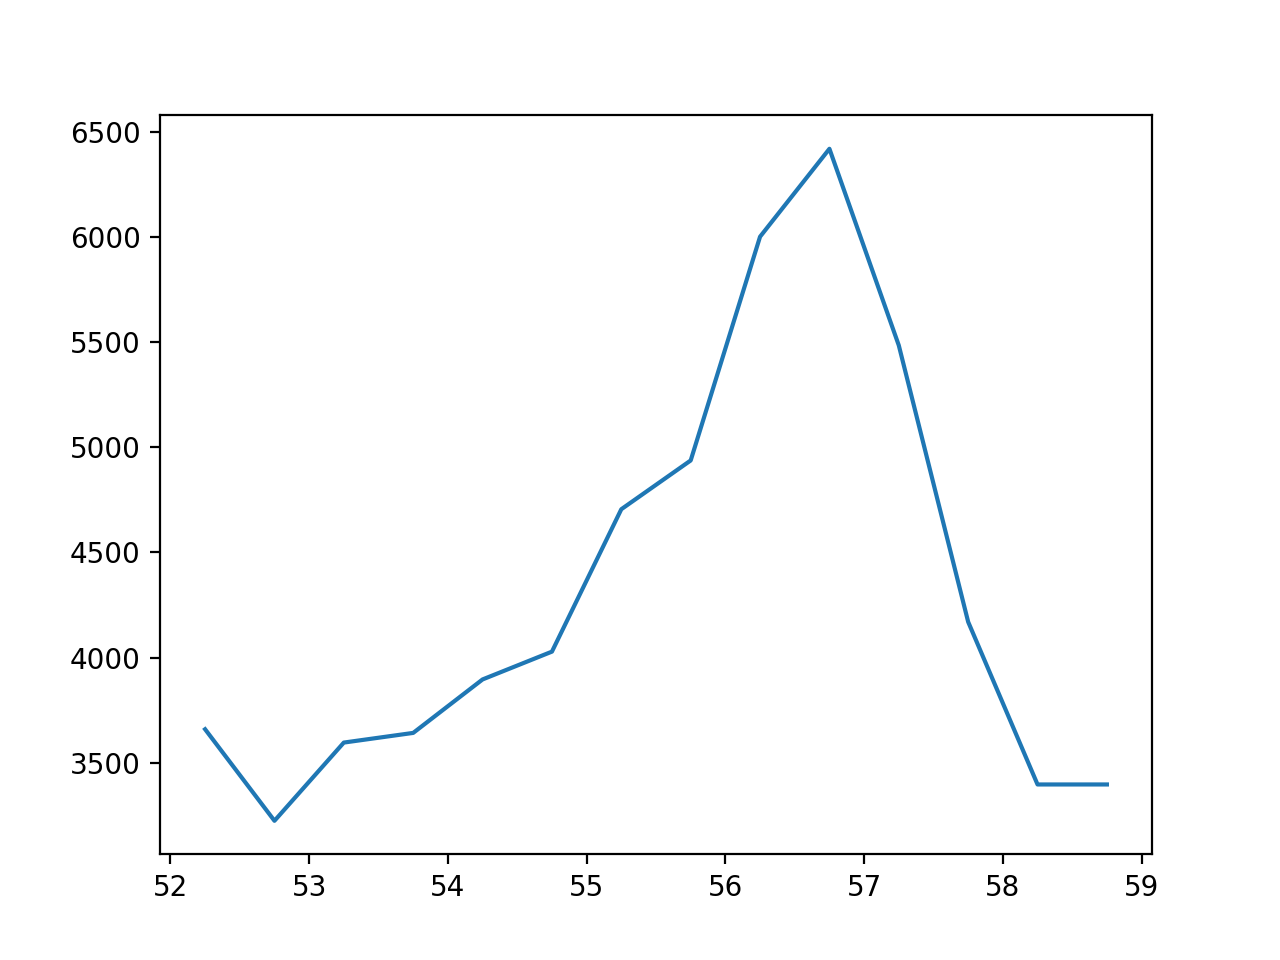

In [14]:
plt.figure()
plt.plot(pk_56.energy, pk_56.I)

In [145]:
params = lmfit.Parameters()
params.add('center', value=56.7, min=56., max=57.)
params.add('height', value=3000., min=2500, max=3500)
params.add('bg', value=3500., min=3200., max=3601.)
params.add('sl', value=1.5, min=1e-3, max=4)
params.add('sr', value=1, min=1e-3, max=4)
params.add('wl', value=0.5, min=0.3, max=.7)
params.add('efw', value=0.5, min=.4, max=2)

In [146]:
def ee_func(x, sl=None, sr=None, wl=None, efw=None, center=None, bg=None, height=None):
    model = EEModel(sl, sr, wl, efw)
    y = model(x-center)
    y *= height / y.max()
    return y + bg

In [172]:
def residual(params, x, data, eps_data):
    y = ee_func(x, **params)
    # print params, y.sum()
    # plt.plot(x, y, label='%s,%s,%s,%s' % (params['sl'], params['sr'],params['wl'],params['efw']))
    return (y-data)/eps_data

In [148]:
x = pk_56.energy
data = pk_56.I
eps_data = 1.
# fit
# plt.figure()
out = lmfit.minimize(residual, params, args=(x, data, eps_data)) #, method='differential_evolution')

In [149]:
out.params

Parameters([('center',
             <Parameter 'center', 56.54560571160566, bounds=[56.0:57.0]>),
            ('height',
             <Parameter 'height', 3053.9571779176295, bounds=[2500:3500]>),
            ('bg',
             <Parameter 'bg', 3407.0044552460972, bounds=[3200.0:3601.0]>),
            ('sl', <Parameter 'sl', 0.62979497262713335, bounds=[0.001:4]>),
            ('sr', <Parameter 'sr', 1.3496642433644936, bounds=[0.001:4]>),
            ('wl', <Parameter 'wl', 0.5, bounds=[0.3:0.7]>),
            ('efw', <Parameter 'efw', 1.2573582494974929, bounds=[0.4:2]>)])

<IPython.core.display.Javascript object>


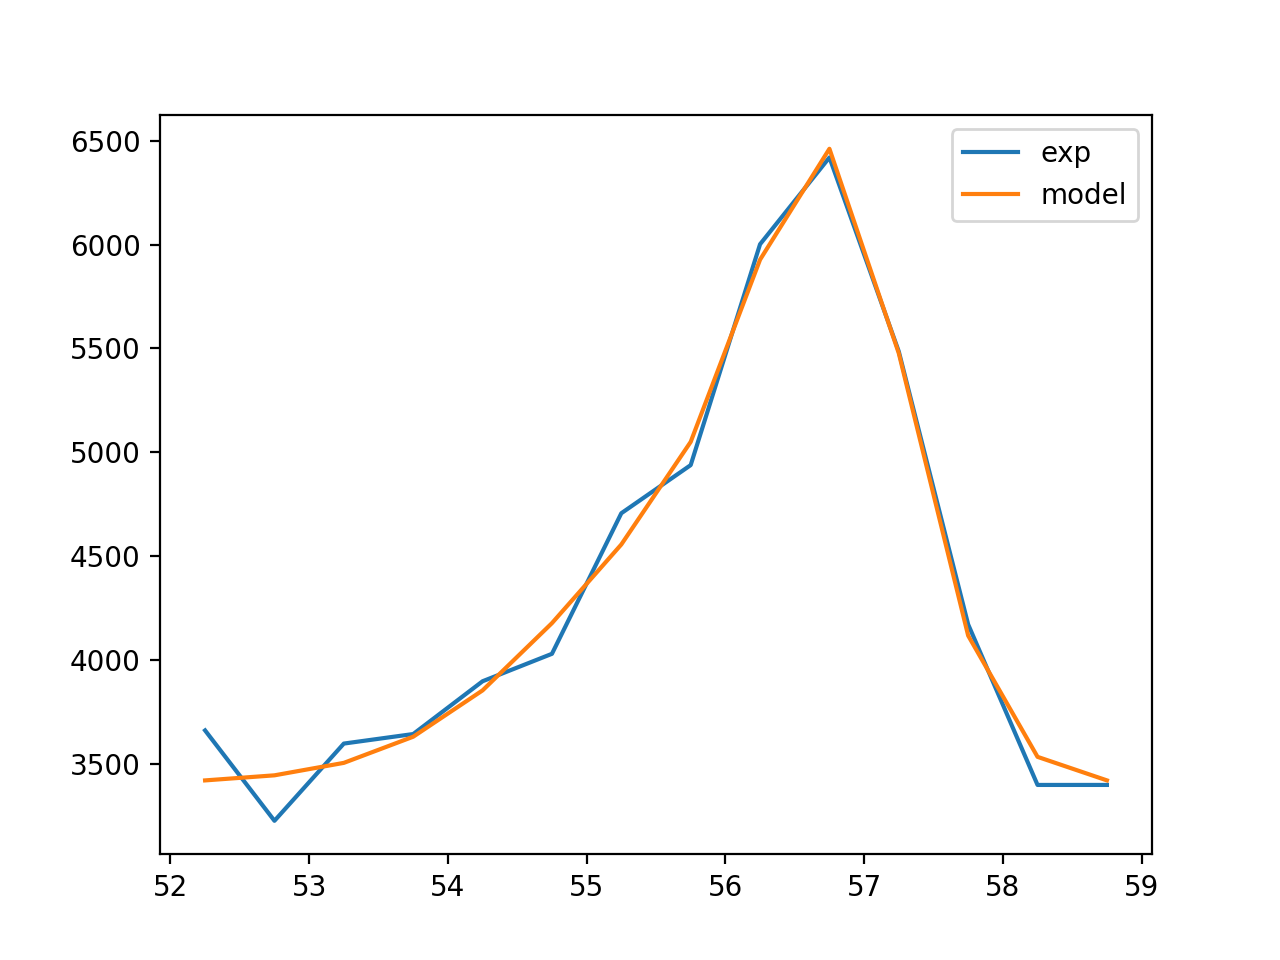

In [150]:
exp = data
plt.figure()
plt.plot(x, exp, label='exp')
model = ee_func(x, **out.params)
model *= data.sum()/model.sum()
plt.plot(x, model, label='model')
residual_ = exp - model
# plt.plot(x, residual_)
plt.legend()

<IPython.core.display.Javascript object>


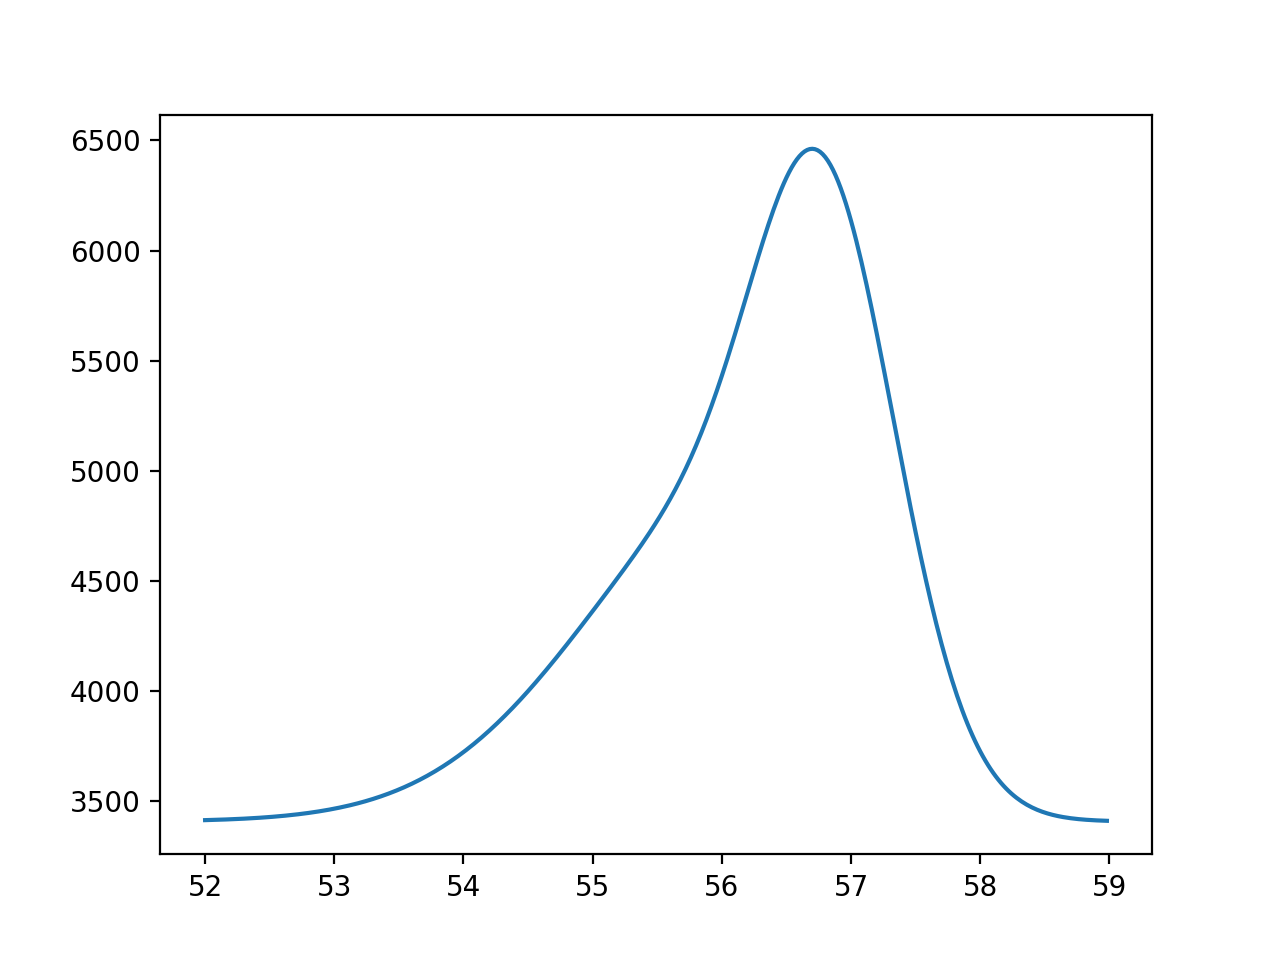

In [138]:
plt.figure()
x1 = np.arange(52, 59, 0.02)
model = ee_func(x1, **out.params)
plt.plot(x1, model)

In [155]:
ps = dict(out.params.valuesdict())
ps['bg'] = 0
x1 = np.arange(52, 59, 0.002)
model = ee_func(x1, **ps)
fm = model.max()
middle = x1[model>fm/2]
print middle[-1] - middle[0]

1.764


# Seems OK. Now need to make this more automatic

In [158]:
pk = pk_56

In [159]:
pk.energy

array([ 52.25,  52.75,  53.25,  53.75,  54.25,  54.75,  55.25,  55.75,
        56.25,  56.75,  57.25,  57.75,  58.25,  58.75])

In [168]:
center = pk.energy[np.argmax(pk.I)]
Emin = pk.energy[0]; Emax = pk.energy[-1]
FWHM = (Emax-Emin)/2
bg = (pk.I[0] + pk.I[-1])/2
height = np.max(pk.I) - bg
height, bg, center, FWHM

(2890.7301030367626, 3528.474222462095, 56.75, 3.25)

In [173]:
params = lmfit.Parameters()
params.add('center', value=center, min=center-FWHM/2, max=57.+FWHM/2)
params.add('height', value=height, min=height*.8, max=height*1.2)
params.add('bg', value=bg, min=bg*.8, max=bg*1.2)
params.add('sl', value=FWHM, min=1e-3, max=FWHM*1.5)
params.add('sr', value=FWHM, min=1e-3, max=FWHM*1.5)
params.add('wl', value=0.5, min=0.3, max=.7)
params.add('efw', value=FWHM, min=FWHM/8, max=FWHM*2)

x = pk.energy
data = pk.I
eps_data = 1.
out = lmfit.minimize(residual, params, args=(x, data, eps_data)) #, method='differential_evolution')

In [ ]:
exp = data
plt.figure()
plt.plot(x, exp, label='exp')

x1 = np.arange(Emin, Emax, (Emax-Emin)/200.)
model = ee_func(x1, **out.params)
plt.plot(x1, model, label='model')
plt.legend()

In [ ]:
ps = dict(out.params.valuesdict())
ps['bg'] = 0
x1 = np.arange(Emin, Emax, (Emax-Emin)/1000.)
model = ee_func(x1, **ps)
fm = model.max()
middle = x1[model>fm/2]
print middle[-1] - middle[0]
plt.figure()
plt.plot(x1, model, label='full')
plt.plot(middle, model[model>fm/2], label='middle')
plt.legend()

# Put things together

In [196]:
def ee_func(x, sl=None, sr=None, wl=None, efw=None, center=None, bg=None, slope=None, height=None):
    model = EEModel(sl, sr, wl, efw)
    y = model(x-center)
    y *= height / y.max()
    return y + bg + (x-center)*slope

def residual(params, x, data, eps_data):
    y = ee_func(x, **params)
    # print params, y.sum()
    # plt.plot(x, y, label='%s,%s,%s,%s' % (params['sl'], params['sr'],params['wl'],params['efw']))
    return (y-data)/eps_data

In [240]:
def fitpk(pk, newfigure=True):
    center = pk.energy[np.argmax(pk.I)]
    Emin = pk.energy[0]; Emax = pk.energy[-1]
    FWHM = (Emax-Emin)/2
    bg = (pk.I[0] + pk.I[-1])/2
    height = np.max(pk.I) - bg
    height, bg, center, FWHM

    params = lmfit.Parameters()
    params.add('center', value=center, min=center-FWHM/2, max=center+FWHM/2)
    params.add('height', value=height, min=height*.8, max=height*1.2)
    params.add('bg', value=bg, min=bg*.8, max=bg*1.2)
    params.add('slope', value=0., min=-height/FWHM, max=height/FWHM)
    params.add('sl', value=FWHM, min=1e-1, max=FWHM*1.5)
    params.add('sr', value=FWHM, min=1e-1, max=FWHM*1.5)
    params.add('wl', value=0.5, min=0.3, max=.7)
    params.add('efw', value=FWHM, min=FWHM/8, max=FWHM*2)

    x = pk.energy
    data = pk.I
    eps_data = pk.E2**.5
    out = lmfit.minimize(residual, params, args=(x, data, eps_data)) 

    exp = data
    if newfigure: plt.figure()
    plt.plot(x, exp, label='exp')

    x1 = np.arange(Emin, Emax, (Emax-Emin)/1000.)
    model = ee_func(x1, **out.params)
    plt.plot(x1, model, label='model')

    ps = dict(out.params.valuesdict())
    ps['bg'] = 0; ps['slope']=0
    model_nobg = ee_func(x1, **ps)
    fm = model_nobg.max()
    middle = x1[model_nobg>fm/2]
    res_FWHM = middle[-1] - middle[0]
    plt.plot(middle, model[model_nobg>fm/2], 'o', mfc='none', label='middle')
    plt.legend()
    return res_FWHM, out.params

In [ ]:
fwhm, fitparams = fitpk(pk_56)

In [ ]:
pk_45 = ie[(40, 49)]

fwhm, fitparams = fitpk(pk_45)
print fwhm

In [ ]:
pk_29 = ie[(23, 34)]

fwhm, fitparams = fitpk(pk_29)
print fwhm

In [ ]:
pk_67 = ie[(64, 70)]

fwhm, fitparams = fitpk(pk_67)
print fwhm

In [ ]:
pk_79 = ie[(77, 81)]

fwhm, fitparams = fitpk(pk_79)
print fwhm

In [ ]:
pk_91 = ie[(88, 92)]

fwhm, fitparams = fitpk(pk_91)
print fwhm

# Loop

In [239]:
pks = [
    (23, 34),
    (40, 49),
    (52, 58.5),
    (64, 70),
    (77, 81),
    (88, 92),
]

<IPython.core.display.Javascript object>


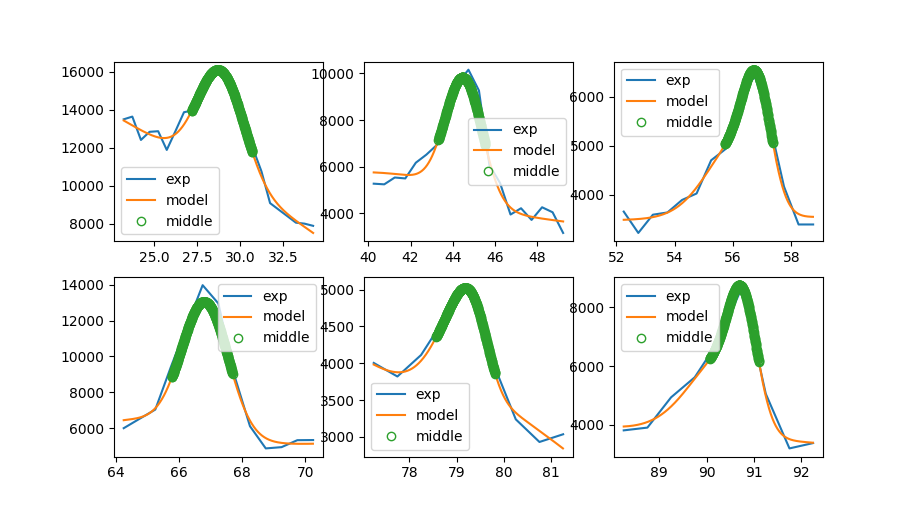

In [252]:
plt.figure(figsize=(8, 4))
N = len(pks)
cols = 3
rows = (N-1)//cols + 1
res = []
for i, (Emin, Emax) in enumerate(pks):
    pk = ie[(Emin, Emax)]
    plt.subplot(rows,cols,i+1)
    fwhm, fitparams = fitpk(pk, newfigure=False)
    res.append((fitparams['center'].value, fwhm))
    continue

In [250]:
res

[(29.069162382503183, 3.5309999999997537),
 (44.189467018853229, 2.2410000000000849),
 (56.551920497022913, 1.6380000000006589),
 (66.593784744081717, 1.926000000000073),
 (79.57104977208266, 1.2440000000015203),
 (90.578000541400797, 1.0360000000012661)]

<IPython.core.display.Javascript object>


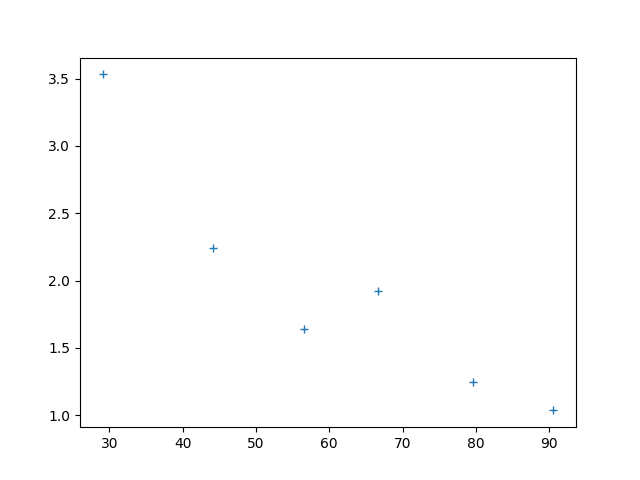

In [255]:
plt.figure()
x,y = np.array(res).T
plt.plot(x,y, '+')

In [256]:
pwd

u'/SNS/users/lj7/notebooks/.rk-work/jnrk-analysis-mcvine-unstable'

In [258]:
np.save('./C4H2I2S-exp.npy', (x,y))